In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, decomposition, metrics, model_selection
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from math import radians, cos, sin, asin, sqrt
import pickle
from matplotlib import pyplot
from utils import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
import xgboost as xgb

In [3]:
def preprocess1(data, is_train=True, use_synthetic_generation=True):
    #Get columns list and remove tripid col and non numerical cols
    cols = list(data.columns)
    cols.remove("tripid")
    cols.remove("pickup_time")
    cols.remove("drop_time")    
    data = data.drop(columns=["tripid"], axis=1)
    
    if is_train:
        #Adjust target label to True or False
        data.loc[data.label == "correct", "label"] = True
        data.loc[data.label == "incorrect", "label"] = False
        data["label"] = data["label"].astype('bool')
        cols.remove("label")
        
    #Fill missing values
    if is_train:
        dataset = fill_missing_val(data, cols)
    else:
        dataset = data
    
    #calculate the distance
    dataset = calculate_distance(dataset)
    
    #Create hour value for timestamps
    dataset["pickup_time"] = data.apply((lambda x: get_hour(x["pickup_time"], "pickup_time")), axis=1).astype("int")
    dataset["drop_time"] = data.apply((lambda x: get_hour(x["drop_time"], "pickup_time")), axis=1).astype("int")

    
    if is_train and use_synthetic_generation:
        #Use SMOTE to resample
        datasetX, datasetY = balance_using_SMOTE(dataset.drop(columns=["label"], axis=1), dataset["label"])
    elif is_train:
        datasetX, datasetY = dataset.drop(columns=["label"], axis=1), dataset["label"]
    else:
        datasetX = dataset
    
    #Bin timestamps
    datasetX = get_binned_DF(datasetX, "pickup_time")
    datasetX = get_binned_DF(datasetX, "drop_time")

    
    #Scale dataset
    datasetX = scale_data(datasetX)
    
    if is_train:
        return datasetX, datasetY
    
    return datasetX

In [4]:
df = pd.read_csv("train.csv")
X, Y = preprocess1(df, use_synthetic_generation=False)

In [18]:
params = {
    "scale_pos_weight": [1],
    "learning_rate": [i*0.01 for i in range(1, 8, 1)],  
    "colsample_bytree": [i*0.1 for i in range(2, 7)],
    "subsample": [i*0.1 for i in range(5, 8)],
    "objective": ['binary:logistic'],
    "reg_alpha": [0.1, 0.3, 0.5, 0.7],
    "max_depth": [8],
    "gamma": [1,3,5,7], 
    "n_estimators": [5000, 15000],
}

In [19]:
xgb_model = xgb.XGBClassifier(silent=False)

In [20]:
search = GridSearchCV(xgb_model, params, cv=5, verbose=4, scoring=metrics.make_scorer(metrics.f1_score))

In [ ]:
results = search.fit(X, Y)

Fitting 5 folds for each of 3360 candidates, totalling 16800 fits
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.972, total=  49.3s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.3s remaining:    0.0s


[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.965, total=  48.2s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.969, total=  43.8s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.969, total=  49.0s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.968, total=  50.4s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total=  50.1s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_d

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.972, total=  49.7s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.965, total=  42.8s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total=  44.3s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.969, total=  47.2s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.970, total=  44.4s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.967, total=  43.9s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.3min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total= 2.4min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.967, total= 2.3min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.966, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.969, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total= 2.1min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.972, total=  42.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.966, total=  42.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.971, total=  42.5s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total=  42.8s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total=  42.5s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  45.5s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  42.9s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.972, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.967, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_e

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total= 2.1min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.972, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learn

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total=  41.3s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total=  41.3s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total=  41.5s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  41.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  41.5s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  41.3s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.968, total=  41.8s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total=  41.5s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total=  41.0s
[CV] colsample_bytree=0.2, gamm

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.967, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.970, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.973, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, 

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.970, total= 2.3min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.970, total=  44.0s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.969, total=  44.9s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.969, total=  44.0s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total=  41.9s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.974, total=  41.5s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.967, total=  40.6s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.966, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.972, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.967, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.04, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total=  42.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total=  41.1s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total=  41.3s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  40.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.973, total=  41.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.966, total=  41.0s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estim

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total=  40.9s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  41.2s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total=  41.4s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.972, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learn

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.973, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.970, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.968, total=  40.5s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total=  41.0s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total=  42.5s
[CV] colsample_bytree=0.2, gamm

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.966, total=  40.1s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  40.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  40.7s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.973, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, 

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total= 2.2min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.967, total= 2.2min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total= 2.2min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.06, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  42.6s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total=  40.9s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.966, total=  41.4s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.966, total=  41.9s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.971, total=  42.7s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.970, total=  42.1s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total=  42.4s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total=  43.3s
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total=  42.5s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.973, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.966, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.5min
[CV] colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.2min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=1, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.2min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.972, total=  46.0s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.966, total=  46.8s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_esti

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.966, total=  50.3s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total=  50.1s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  49.7s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total=  49.6s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total=  49.9s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.972, total=  50.2s
[CV] colsample_bytree=0.2, gamma=3, learning_r

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.974, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.2min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.972, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.1min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.974, total= 2.2min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.2min
[CV] colsample_bytree=0.2,

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.967, total=  42.2s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.970, total=  42.2s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.972, total=  40.8s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.971, total=  45.7s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.968, total=  45.8s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.974, total=  46.5s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_d

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total=  45.2s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total=  44.2s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  44.8s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.2min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.970, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.2min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.975, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.02, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.1min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.967, total=  42.5s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.970, total=  41.7s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.971, total=  40.7s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  41.5s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  41.8s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.974, total=  41.7s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.974, total=  41.4s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.968, total=  41.1s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.970, total=  42.1s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total= 2.1min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.974, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.967, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.03, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.1min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total=  39.7s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  39.7s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.974, total=  40.8s
[CV] colsample_bytree=0.2, gamma=3, learning_r

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.974, total=  41.2s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  42.5s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  41.1s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total=  39.9s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.972, total=  40.3s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total=  40.1s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.974, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total= 2.1min
[CV] colsample_bytree=0.2,

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.972, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.04, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.971, total=  41.5s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.968, total=  41.5s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.974, total=  41.6s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_d

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.974, total=  39.7s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total=  40.2s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total=  40.6s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.971, total=  41.4s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.971, total=  41.4s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.968, total=  41.8s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.969, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.974, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.967, total= 2.3min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.3min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.970, total= 2.3min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.3min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.3min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.05, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.974, total= 2.2min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.973, total=  46.4s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.967, total=  45.9s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.971, total=  45.8s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  46.9s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  46.8s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  46.8s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  45.8s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.974, total= 2.3min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.967, total= 2.4min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_e

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.06, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.974, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learn

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.974, total=  41.2s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  40.0s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  40.9s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total=  40.1s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total=  39.5s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  39.4s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.970, total=  40.1s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.975, total=  41.0s
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  41.5s
[CV] colsample_bytree=0.2, gamm

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.968, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.971, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total= 2.0min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.969, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.969, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.975, total= 2.1min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, 

[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.974, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.967, total= 2.0min
[CV] colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=3, learning_rate=0.07, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.7000000000000001, score=0.972, total= 2.1min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.970, total=  41.3s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.971, total=  41.7s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.5, score=0.968, total=  41.5s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, obj

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total=  42.0s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.973, total=  40.8s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.7000000000000001, score=0.967, total=  40.5s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.967, total= 2.1min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.5, score=0.971, total= 2.1min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total= 2.4min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total= 2.4min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.975, total= 2.3min
[CV] colsam

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.975, total= 2.4min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.968, total= 2.4min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=15000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.5, score=0.972, total= 2.4min
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.01, max_depth=8, n_estimators=1500

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.970, total=  48.4s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total=  48.3s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.1, scale_pos_weight=1, subsample=0.6000000000000001, score=0.968, total=  47.5s
[CV] colsample_b

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.3, scale_pos_weight=1, subsample=0.7000000000000001, score=0.969, total=  41.0s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.975, total=  42.9s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.5, scale_pos_weight=1, subsample=0.5, score=0.967, total=  48.9s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estim

[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.967, total=  48.2s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.971, total=  48.0s
[CV] colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001 
[CV]  colsample_bytree=0.2, gamma=5, learning_rate=0.02, max_depth=8, n_estimators=5000, objective=binary:logistic, reg_alpha=0.7, scale_pos_weight=1, subsample=0.6000000000000001, score=0.972, total=  47.1s
[CV] colsample_b

In [12]:
best_model = results.best_estimator_
best_model

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=6, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=35000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.9,
              reg_lambda=1, scale_pos_weight=1, silent=False,
              subsample=0.7000000000000001, tree_method=None,
              validate_parameters=False, verbosity=None)

In [13]:
results.best_score_

0.9492310716397829

In [135]:
x, x_validate, y, y_validate = model_selection.train_test_split(X, Y, test_size=0.1, random_state=42)
x_tr, x_te, y_tr, y_te = model_selection.train_test_split(x, y, test_size=0.175, random_state=42)

In [136]:
eval_set1 = [(x_tr, y_tr), (x_te, y_te)]
eval_metric1 = ["auc","error"]

In [165]:
results = model4.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

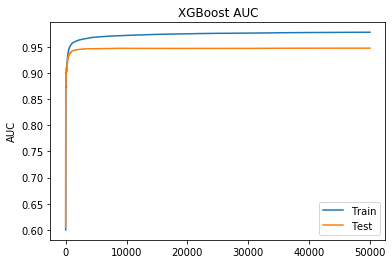

In [186]:
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

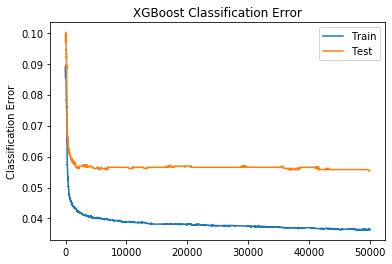

In [187]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [15]:
temp_model = models[2]

In [51]:
temp_model2 = models[7]

In [44]:
modelCount = 0
for model in models:
    count = 0
    print("MODEL:", modelCount)
    for imp in temp_model2.feature_importances_:
        print(cols2[count], imp)
        count += 1
    modelCount += 1

MODEL: 0
0 0.10220718
1 0.082426496
2 0.02722826
3 0.029743383
4 0.019243227
5 0.054467015
6 0.04218942
7 0.011823909
8 0.004366155
9 0.0
10 0.008116734
11 0.003055509
12 0.008724934
13 0.02266054
14 0.008568795
15 0.01259461
16 0.022347387
17 0.016784746
18 0.014412417
19 0.020254219
20 0.016610643
21 0.025419962
22 0.010967209
23 0.013484519
24 0.0172702
25 0.023546627
26 0.013625785
27 0.0067540393
28 0.024642622
29 0.012295193
30 0.0096653765
31 0.013180087
32 0.00732311
33 0.007363757
34 0.0
35 0.0055287043
36 0.0
37 0.010399229
38 0.014921948
39 0.019594578
40 0.030434474
41 0.026652468
42 0.015903128
43 0.026930898
44 0.018275006
45 0.010642718
46 0.02797758
47 0.01425777
48 0.017561518
49 0.018236607
50 0.015835816
51 0.007858519
52 0.0056250333
53 0.0
54 0.0
MODEL: 1
0 0.10220718
1 0.082426496
2 0.02722826
3 0.029743383
4 0.019243227
5 0.054467015
6 0.04218942
7 0.011823909
8 0.004366155
9 0.0
10 0.008116734
11 0.003055509
12 0.008724934
13 0.02266054
14 0.008568795
15 0.01259

In [15]:
pickle.dump(best_model, open("xgb_mode_random_cv_1", 'wb'))

In [16]:
test_data = pd.read_csv("test.csv")
X_pred = preprocess1(test_data, False, False)
X_pred.columns

RangeIndex(start=0, stop=55, step=1)

In [17]:
predictions = best_model.predict(X_pred)

In [18]:
test_results = pd.DataFrame(predictions, columns=["prediction"])

In [19]:
test_results["tripid"] = test_data["tripid"]
test_results["prediction"] = test_results["prediction"].astype("int")
test_results.head()

,prediction,tripid
0,1,213284604
1,1,213286352
2,1,213293973
3,0,213294622
4,0,213298687


In [20]:
test_results[["tripid", "prediction"]].to_csv("predictions10csv", index=False)